In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

2024-11-11 03:01:35.722761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 03:01:35.723202: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 03:01:35.725218: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 03:01:35.730638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731274295.739734 1661580 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731274295.74

## Data Import and Processing

In [5]:
# X = np.loadtxt('training_data_root2sigma/training_samples.txt')
# y = np.loadtxt('training_data_root2sigma/chisqs.txt')

# mask = ~np.isinf(y)
# X = X[mask]
# y = y[mask]

In [ ]:
# X, X_rem, y, y_rem = train_test_split(X, y, test_size=0.5, random_state=42)

In [2]:
X = np.loadtxt('../main/training_data/training_samples.txt')
y = np.loadtxt('../main/training_data/chisqs.txt')

In [3]:
median = np.median(X[:, 0])
std = np.std(X[:, 0])

lower_bound = median - 3 * std
upper_bound = median + 3 * std

mask = (X[:, 0] >= lower_bound) & (X[:, 0] <= upper_bound)

X = X[mask]
y = y[mask]

In [4]:
val_frac, test_frac = 0.2, 0.2
total = val_frac + test_frac

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=total, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_frac/total), random_state=42)

## Model Creation and Training

In [5]:
tf.keras.utils.set_random_seed(42)

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

best_model = tf.keras.Sequential([
    input_layer,
    norm_layer,
    tf.keras.layers.Dense(400, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
best_model.compile(loss='mse', optimizer=optimizer, metrics=["MeanSquaredError"])

stop_early = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=1)

Epoch 1/1000


2024-11-11 03:01:44.566821: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MeanSquaredError: 1669.7013 - loss: 1669.7280 - val_MeanSquaredError: 1504.6887 - val_loss: 1504.7158
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - MeanSquaredError: 1340.7527 - loss: 1340.7802 - val_MeanSquaredError: 666.1669 - val_loss: 666.1956
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - MeanSquaredError: 444.0178 - loss: 444.0470 - val_MeanSquaredError: 77.6223 - val_loss: 77.6529
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - MeanSquaredError: 66.9548 - loss: 66.9854 - val_MeanSquaredError: 58.0892 - val_loss: 58.1198
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - MeanSquaredError: 53.6498 - loss: 53.6805 - val_MeanSquaredError: 49.7159 - val_loss: 49.7465
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - MeanSquaredError: 46.1860 - loss: 46.2166 - val_MeanSquaredError: 43.2946 - val_loss: 43.3252
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - MeanSquaredError: 40.3185 - loss: 40.3491 -

Text(0.5, 0, 'Epochs')

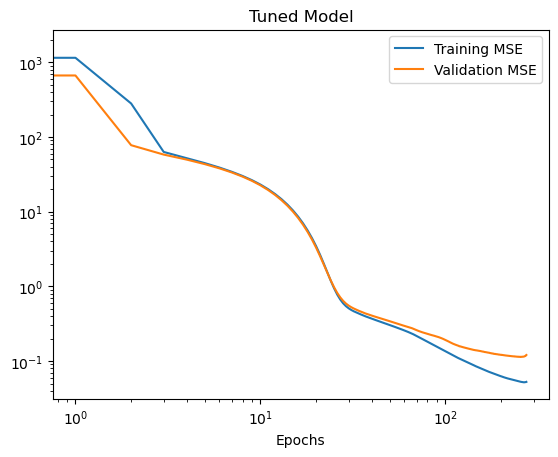

In [6]:
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xscale('log')
plt.yscale('log')
plt.title('Tuned Model')
plt.legend()
plt.xlabel('Epochs')
#plt.savefig('plots/Tuned_Model.png',dpi=300,bbox_inches='tight')

In [7]:
best_test_loss, best_test_mse = best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - MeanSquaredError: 0.0769 - loss: 0.1038


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


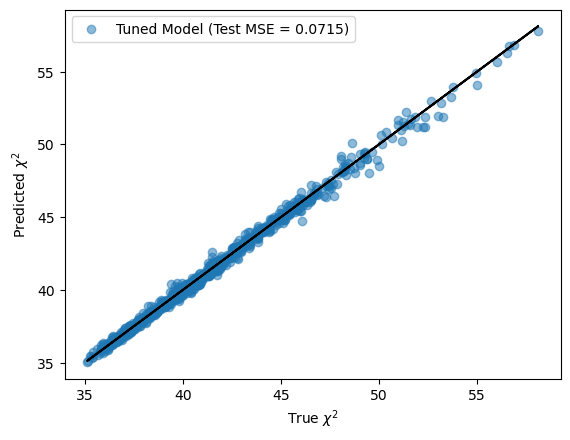

In [8]:
plt.scatter(y_test, best_model.predict(X_test), label=f'Tuned Model (Test MSE = {best_test_mse:.4f})', alpha=0.5)
plt.plot(y_test, y_test, marker=' ', c='k')
plt.ylabel('Predicted $\chi^2$')
plt.xlabel('True $\chi^2$')
plt.legend()
#plt.savefig('plots/Tuned_Model_Test.png',dpi=300,bbox_inches='tight')

In [9]:
best_model.save('script_chisq_emulator_256_32.keras')